
### **Entendimiento de los datos**

In [197]:
# Important imports
#Used Libraries
from pyspark.sql import SparkSession
from pyspark.sql import functions
from pyspark.sql.types import StructType
from pyspark import SparkContext, SparkConf, SQLContext
from pyspark.sql.types import FloatType, StringType, IntegerType, DateType
from pyspark.sql.functions import udf, col, length, isnan, when, count, length, trim, regexp_extract
from pyspark.sql.functions import col, to_date
import pyspark.sql.functions as f
from pyspark.sql.types import NumericType
import os
from pyspark.sql import types as t
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from pyspark.sql.functions import col
from wordcloud import WordCloud
import warnings
from scipy.stats import pearsonr
import plotly.express as px
import matplotlib.pyplot as plt


In [23]:
# Given Credentials
db_user = 'Estudiante_65_202415'
db_psswd = 'Estudiante_202010409'

connection_properties = {
    "user": db_user,
    "password": db_psswd,
    "driver": "com.mysql.cj.jdbc.Driver"
}

default_string_connection = 'jdbc:mysql://157.253.236.120:8080/WWImportersTransactional'

# Ignorar las advertencias de FutureWarning
warnings.filterwarnings("ignore", category=FutureWarning)

In [3]:
# WINDOWS - Compatible with VM  
#path_jar_driver = 'C:\Program Files (x86)\MySQL\Connector J 8.0\mysql-connector-java-8.0.28.jar'

# LINUX users: to download the jar wget https://dev.mysql.com/get/Downloads/Connector-J/mysql-connector-java-8.0.28.tar.gz
path_jar_driver = '/opt/mysql/lib/mysql-connector-java-8.0.28.jar'

In [156]:
import modules.spark_session_module
import modules.mysql_connector
from modules.graphicsutil import *


### **Cargue de datos**

In [4]:
spark = modules.spark_session_module.create_spark_session(path_jar_driver)

24/11/02 08:34:07 WARN Utils: Your hostname, willp resolves to a loopback address: 127.0.1.1; using 192.168.1.113 instead (on interface wlp9s0)
24/11/02 08:34:07 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/11/02 08:34:08 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
24/11/02 08:34:09 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.
/home/willp/anaconda3/lib/python3.11/site-packages/pyspark/sql/context.py:112: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


In [27]:
conn = modules.mysql_connector.MySQLConnector(spark=spark, connection_properties=connection_properties, url=default_string_connection)

In [28]:
sql_service_area = 'RaSaTransaccional.FuenteAreasDeServicio_Copia_E'

In [42]:
areas  = conn.get_dataframe(sql_service_area)
areas.show()

+------------------+--------------------+-------------+-----------------+----------+------------+------+--------+-----+
|IdAreaDeServicio_T|NombreAreaDeServicio|IdGeografia_T|          Condado|    Estado|PoblacionAct|  Area|Densidad|Fecha|
+------------------+--------------------+-------------+-----------------+----------+------------+------+--------+-----+
|         100622017|New Jersey - Medi...|        34005|Burlington County|New Jersey|    464269.0| 805.0|   577.0| 2017|
|         101012018|New Jersey - Medi...|        34031|   Passaic County|New Jersey|    518117.0| 185.0|  2801.0| 2018|
|          10132017|BlueOptions16842F...|        12031|     Duval County|   Florida|    999935.0| 774.0|  1292.0| 2017|
|         101982018|New Jersey - Medi...|        34003|    Bergen County|New Jersey|    953819.0| 234.0|  4076.0| 2018|
|         102012017|New Jersey - Medi...|        34021|    Mercer County|New Jersey|    385898.0| 226.0|  1708.0| 2017|
|         102012017|New Jersey - Medi...

La tabla representa un conjunto de datos geográficos y demográficos que describe diversas áreas de servicio de seguros de salud en diferentes condados de Estados Unidos. En particular, la tabla contiene información que vincula áreas de servicio específicas a condados y estados, junto con detalles sobre la población, el área geográfica, y la densidad de población para cada combinación.

La tabla sirve para proporcionar un contexto detallado de cómo se distribuyen las áreas de servicio de las compañías de seguros de salud en términos de ubicación geográfica y características demográficas. Esto puede ser útil para análisis de cobertura de seguros, estudios de mercado, planificación de recursos o políticas públicas, y para entender mejor las dinámicas poblacionales en relación con los servicios de salud ofrecidos en esas regiones.

#### **¿Qué es una fila de cada fuente compartida?**
Una fila de la tabla que compartiste representa un registro con información específica sobre un área de servicio en un condado particular. Cada fila incluye los siguientes datos:

- **IdAreaDeServicio_T:** Un identificador único para el área de servicio.
- **NombreAreaDeServicio:** El nombre del área de servicio.
- **IdGeografia_T:** Un identificador único para la geografía correspondiente.
- **Condado:** El nombre del condado donde se encuentra el área de servicio.
- **Estado:** El estado en el que se encuentra el condado.
- **PoblacionAct:** La población actual del área de servicio.
- **Area:** El área geográfica en unidades específicas (probablemente millas cuadradas o kilómetros cuadrados).
- **Densidad:** La densidad de población del área.
- **Fecha:** El año en que se registraron los datos.

In [31]:
# Schema
areas.schema

StructType([StructField('IdAreaDeServicio_T', IntegerType(), True), StructField('NombreAreaDeServicio', StringType(), True), StructField('IdGeografia_T', IntegerType(), True), StructField('Condado', StringType(), True), StructField('Estado', StringType(), True), StructField('PoblacionAct', DoubleType(), True), StructField('Area', DoubleType(), True), StructField('Densidad', DoubleType(), True), StructField('Fecha', IntegerType(), True)])

In [33]:
print((areas.count(), len(areas.columns)))

(188815, 9)


La tabla cuenta con 188.815 registros y nueve columnas 

#### Revision de Columnas String

El resultado de la siguiente funcion pone de manifiesto , que ninguna de las cadenas de string se encuentra incompleta ,ni tiene cadenas vacias, sin embargo, en el apartado de longitud NombreAreaDeServicio, es un string que se puede procesar para tratar procesar y estructurar, informacion util sobre el area de servicio.


In [54]:
def validar_columnas_string(df, columnas_string):
    ejemplos_problemas = []

    for columna in columnas_string:
        print(f"Validando la columna: {columna}")
        
        # 1. Verificar valores nulos
        nulos_df = df.filter(col(columna).isNull()).toPandas()
        nulos = nulos_df.shape[0]
        print(f" - Valores nulos: {nulos}")
        if nulos > 0:
            nulos_df['Columna'] = columna
            nulos_df['Regla No Cumplida'] = 'Valor nulo'
            ejemplos_problemas.append(nulos_df)
        
        # 2. Verificar cadenas vacías
        vacias_df = df.filter(col(columna) == '').toPandas()
        cadenas_vacias = vacias_df.shape[0]
        print(f" - Cadenas vacías: {cadenas_vacias}")
        if cadenas_vacias > 0:
            vacias_df['Columna'] = columna
            vacias_df['Regla No Cumplida'] = 'Cadena vacía'
            ejemplos_problemas.append(vacias_df)
        
        # 3. Eliminar espacios en blanco al inicio y al final
        df = df.withColumn(columna, trim(col(columna)))
        
        # 4. Verificar la longitud de las cadenas (por ejemplo, máximo 50 caracteres)
        longitud_excesiva_df = df.filter(length(col(columna)) > 50).toPandas()
        longitud_excesiva = longitud_excesiva_df.shape[0]
        print(f" - Cadenas con longitud excesiva (>50 caracteres): {longitud_excesiva}")
        if longitud_excesiva > 0:
            longitud_excesiva_df['Columna'] = columna
            longitud_excesiva_df['Regla No Cumplida'] = 'Longitud excesiva'
            ejemplos_problemas.append(longitud_excesiva_df)
        
    # Concatenar todos los ejemplos en un solo DataFrame de pandas
    if ejemplos_problemas:
        return pd.concat(ejemplos_problemas, ignore_index=True)
    else:
        return pd.DataFrame()

# Lista de columnas de tipo string a validar
columnas_string = ['NombreAreaDeServicio', 'Condado', 'Estado']

# Validar las columnas de tipo string
df = validar_columnas_string(areas, columnas_string)

df

Validando la columna: NombreAreaDeServicio
 - Valores nulos: 0
 - Cadenas vacías: 0


 - Cadenas con longitud excesiva (>50 caracteres): 45650
Validando la columna: Condado
 - Valores nulos: 0
 - Cadenas vacías: 0


 - Cadenas con longitud excesiva (>50 caracteres): 0
Validando la columna: Estado
 - Valores nulos: 0
 - Cadenas vacías: 0
 - Cadenas con longitud excesiva (>50 caracteres): 0


,IdAreaDeServicio_T,NombreAreaDeServicio,IdGeografia_T,Condado,Estado,PoblacionAct,Area,Densidad,Fecha,Columna,Regla No Cumplida
0,107682017.0,GHC-SCW Individual HMO Service Area94529WI0210...,55045.0,Green County,Wisconsin,36988.0,583.0,63.0,2017,NombreAreaDeServicio,Longitud excesiva
1,107952018.0,GHC-SCW Individual HMO Select Service Area9452...,55055.0,Jefferson County,Wisconsin,84943.0,556.0,153.0,2018,NombreAreaDeServicio,Longitud excesiva
2,111462017.0,Matthew Thornton Hlth Plan(Anthem BCBS)All9675...,33003.0,Carroll County,New Hampshire,50107.0,934.0,54.0,2017,NombreAreaDeServicio,Longitud excesiva
3,111712017.0,Matthew Thornton Hlth Plan(Anthem BCBS)All9675...,33019.0,Sullivan County,New Hampshire,43063.0,537.0,80.0,2017,NombreAreaDeServicio,Longitud excesiva
4,111822017.0,Matthew Thornton Hlth Plan(Anthem BCBS)All9675...,33007.0,CoÃ¶s County,New Hampshire,31268.0,1801.0,17.0,2017,NombreAreaDeServicio,Longitud excesiva
...,...,...,...,...,...,...,...,...,...,...,...
45645,65762017.0,"BCBS Healthcare Plan of Georgia, Inc.0849046GA...",13053.0,Chattahoochee County,Georgia,9048.0,249.0,36.0,2017,NombreAreaDeServicio,Longitud excesiva
45646,14162018.0,Health Alliance Elite w K320129IL0330054-03201...,51549.0,Vermilion County,Illinois,73095.0,898.0,81.0,2018,NombreAreaDeServicio,Longitud excesiva
45647,19622017.0,Ambetter from Sunshine Health21663FL0130009-01...,36309.0,Pinellas County,Florida,956615.0,280.0,3416.0,2017,NombreAreaDeServicio,Longitud excesiva
45648,19402017.0,Ambetter from Sunshine Health21663FL0130009-01...,12097.0,Osceola County,Florida,403282.0,1322.0,305.0,2017,NombreAreaDeServicio,Longitud excesiva


In [75]:
valores_unicos_estado = areas.select("Estado").distinct()
valores_unicos_estado.count()


35

In [74]:
# Obtener los valores únicos de la columna 'Condado'
valores_unicos_condado = areas.select("Condado").distinct()
valores_unicos_condado.count()

1398

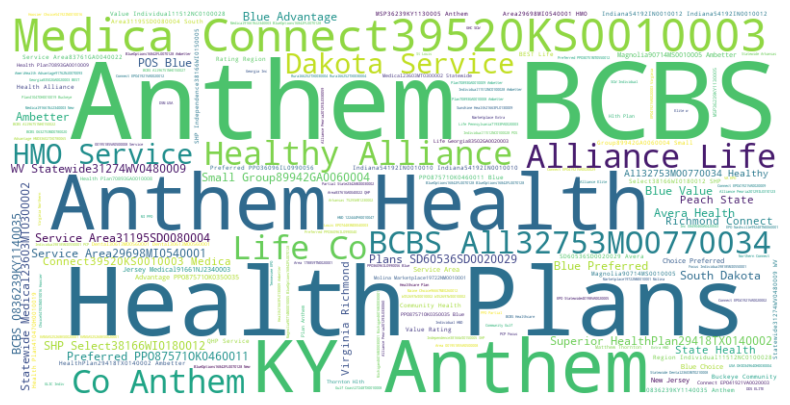

In [57]:

# Extraer los nombres de áreas de servicio desde el DataFrame de Spark
# Convertir la columna 'NombreAreaDeServicio' en una lista de Python
nombres_areas_servicio = areas.select("NombreAreaDeServicio").rdd.flatMap(lambda x: x).collect()

# Unir todos los nombres en un solo texto
texto_unido = " ".join(nombres_areas_servicio)

# Crear la nube de palabras
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(texto_unido)

# Mostrar la nube de palabras
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')  # Desactivar los ejes
plt.show()


**Proveedores de Seguros de Salud**:
- Anthem, BCBS, KY Anthem: Muestra la prominencia de grandes proveedores de seguros de salud, como Anthem y Blue Cross Blue Shield (BCBS). Esto indica que estas compañías tienen una presencia importante en las áreas de servicio descritas.
Medica, Alliance Life: Otros proveedores de seguros de salud también tienen un papel relevante, lo que sugiere una variedad de opciones de cobertura en el sistema de salud.

**Insights Potenciales:**
- Dominancia de Proveedores: Anthem y BCBS aparecen con gran prominencia, lo que podría indicar que son proveedores líderes en el mercado de seguros de salud.

**Especificaciones de los Planes**
- Service Area, Connect39520KS0010003: Estas referencias probablemente se relacionan con identificadores específicos para las áreas de servicio, lo que podría ser útil para rastrear o gestionar los planes.

**Tipos de Planes de Salud**
- HMO, POS, Health Plans: La presencia de estos términos indica que los datos probablemente se refieren a diferentes tipos de planes de salud, como Health Maintenance Organizations (HMO) y Point of Service (POS). Esto refleja la diversidad de opciones de planes disponibles para los asegurados.
- Preferred, Blue Advantage: Términos como estos indican diferentes niveles de cobertura y servicios especiales que se ofrecen a los asegurados.


### **Análisis de calidad de datos**

#### **Completitud y Validez de los datos**

De los 188815 registros totales existen 43573 duplicados lo cual deja como resultado 145242 sin duplicados. 

Por el lado de los valores vacíos en las columnas luego de validar vacíos las siguientes columnas tienen un numero significativo de vacíos:
- número de vacíos para columna IdAreaDeServicio_T: 4841
- número de vacíos para columna IdGeografia_T: 4841
- número de vacíos para columna Area: 1835
- número de vacíos para columna Densidad: 1835

RaSa no cuenta con información de 15 estados, comparando la lista Alpes
- California
- Colorado
- Connecticut
- Idaho
- Iowa
- Maryland
- Massachusetts
- Minnesota
- Nebraska
- Nevada
- New York
- Rhode Island
- Utah
- Vermont
- Washington 

Por otro lado, de los 3243 que hay en Alpes de condados, solo tienen información sobre 1398 condados 

En el Caso de la columna Área, posee valores, negativos, lo cual carece de sentido, la cantidad de registros con esa área es: 6177, por otro lado, analizando su distribution arrojo lo siguiente:
Analizando los datos más extremos de la población actual, y tomando un ejemplo:

![Tabla Moviemientos](./imagenes/extremePopulation.png)

Y haciendo una simple búsqueda en google, la población de ese condado en el 2018 fue 249,964 y una densidad de 207,15 hab./km² por ende se debe hacer una validation de la data historica. 
En el caso del registro encontrado tiene la cifra exorbitante de 6,430,260,000 hab. y la densidad no es real.

Si bien Fecha no es claro su uso, tiene algunos valores invalidos, es decir, menor que 1900 alrededor de 6282 fechas que posiblemente pueden estar mal, se debe validar con el negocio su validez. 



In [95]:
# Filtrar filas con valores negativos en las columnas mencionadas
valores_negativos_fecha = areas.filter((col("Fecha") > 2024) | (col("Fecha") < 1900))

# Mostrar las filas con valores negativos
valores_negativos_fecha.count()

6282

In [61]:
total_filas = areas.count()
areas_not_dup = areas.dropDuplicates()
filas_sin_duplicados = areas_not_dup.count()
filas_duplicadas = total_filas - filas_sin_duplicados

print(f"Total de filas: {total_filas}")
print(f"Total de filas sin duplicados: {filas_sin_duplicados}")
print(f"Total de filas duplicadas: {filas_duplicadas}")


Total de filas: 188815
Total de filas sin duplicados: 145242
Total de filas duplicadas: 43573


In [78]:
# Crear DataFrames separados para cada columna con valores negativos
poblacion_negativa = areas.filter(col("PoblacionAct") < 0)
area_negativa = areas.filter(col("Area") < 0)
densidad_negativa = areas.filter(col("Densidad") < 0)
idgeografia_negativa = areas.filter(col("IdGeografia_T") < 0)

# Mostrar algunos ejemplos de cada DataFrame
print("Filas con valores negativos en PoblacionAct:")
poblacion_negativa.show()



Filas con valores negativos en PoblacionAct:
+------------------+--------------------+-------------+-------+------+------------+----+--------+-----+
|IdAreaDeServicio_T|NombreAreaDeServicio|IdGeografia_T|Condado|Estado|PoblacionAct|Area|Densidad|Fecha|
+------------------+--------------------+-------------+-------+------+------------+----+--------+-----+
+------------------+--------------------+-------------+-------+------+------------+----+--------+-----+



In [79]:
print("Filas con valores negativos en Area:")
area_negativa.show()



Filas con valores negativos en Area:
+------------------+--------------------+-------------+----------------+--------------+------------+-------+--------+-----+
|IdAreaDeServicio_T|NombreAreaDeServicio|IdGeografia_T|         Condado|        Estado|PoblacionAct|   Area|Densidad|Fecha|
+------------------+--------------------+-------------+----------------+--------------+------------+-------+--------+-----+
|          66992017|WI52697WI0010002-...|        55037| Florence County|     Wisconsin|      4593.0| -488.0|     9.0| 2017|
|           1802017|POS Blue Value Ra...|        37159|    Rowan County|North Carolina|    148150.0| -524.0|   283.0| 2017|
|          29762018|Ambetter from Sup...|        48439|  Tarrant County|         Texas|   2126480.0| -864.0|  2461.0| 2018|
|          68672018|Indiana54192IN001...|        18031|  Decatur County|       Indiana|     26320.0| -373.0|    71.0| 2018|
|          92932017|BEST Life Georgia...|        13005|    Bacon County|       Georgia|     110

In [80]:
area_negativa.count()

6177

In [81]:
print("Filas con valores negativos en Densidad:")
densidad_negativa.show()




Filas con valores negativos en Densidad:
+------------------+--------------------+-------------+-------+------+------------+----+--------+-----+
|IdAreaDeServicio_T|NombreAreaDeServicio|IdGeografia_T|Condado|Estado|PoblacionAct|Area|Densidad|Fecha|
+------------------+--------------------+-------------+-------+------+------------+----+--------+-----+
+------------------+--------------------+-------------+-------+------+------------+----+--------+-----+



In [82]:
print("Filas con valores negativos en IdGeografia_T:")
idgeografia_negativa.show()

Filas con valores negativos en IdGeografia_T:
+------------------+--------------------+-------------+-------+------+------------+----+--------+-----+
|IdAreaDeServicio_T|NombreAreaDeServicio|IdGeografia_T|Condado|Estado|PoblacionAct|Area|Densidad|Fecha|
+------------------+--------------------+-------------+-------+------+------------+----+--------+-----+
+------------------+--------------------+-------------+-------+------+------------+----+--------+-----+



In [63]:
def contar_vacios(df):
    resultados = []
    for c in df.columns:
        vacios = df.filter(df[c].isNull()).count()
        if vacios!=0:
            print('número de vacíos para columna '+c+': '+str( vacios ))
            resultados.append(vacios)
    return resultados


def cardinalidad(df):
    resultado = {}
    for c in df.columns:
        cardinalidad = df.select(col(c)).distinct().count()
        if cardinalidad>=df.count()*0.5:
            resultado[c] = cardinalidad
    return resultado

In [64]:
contar_vacios(areas_not_dup)

número de vacíos para columna IdAreaDeServicio_T: 4841
número de vacíos para columna IdGeografia_T: 4841
número de vacíos para columna Area: 1835
número de vacíos para columna Densidad: 1835


[4841, 4841, 1835, 1835]

#### **Cardinalidad**
Ninguna de las columnas tiene una cardinalidad superior al 50%

In [66]:
cardinalidad(areas_not_dup)

{}

#### **Consistencia de los datos**
- **Consistencia Estructural:**
- - PoblacionAct: no deberia ser un tipo flotante deben ser cantidades fijas es decir de tipo entero
- - NombreAreaDeServicio: Podría estar estructurado en varias columnas de esa forma resulta más facil su analisis y no un texto que contiene demasiado detalle.
- - Densidad: Puede ser una medida, o valor calculado, dado si se conoce la población y el área se puede calcular la densidad.
- **Consistencia Semántica:**
- - Existe una columna que se llama **IdGeografia_T** puede ser un identificador a otra tabla que podría tener información sobre el área el condado y el estado y pues se podría considerar revisar si no se está duplicando los datos porque semánticamente representan lo mismo. 
- **Consistencia Contenido:** 
- - **NombreAreaDeServicio** tiene demasiada información no estructurada no solo el nombre del área de servicio tiene un codigo que posiblemente podría extraerse para tener la data mejor estructurada y facilitar las consultas. 
- - **Área** Hay áreas negativas, se debe ajustarse por parte del negocio o no debe tenerse en cuenta en siguientes fases. 

### **Analisis Descriptivo**

In [172]:
df_areas_numeric_vars = areas_not_dup.drop("IdAreaDeServicio_T", "NombreAreaDeServicio", "Condado", "Estado")


In [173]:
df_areas_numeric_vars.show(5)

+-------------+------------+------+--------+-----+
|IdGeografia_T|PoblacionAct|  Area|Densidad|Fecha|
+-------------+------------+------+--------+-----+
|        12083|    385915.0|1579.0|   244.0| 2017|
|        29151|     13379.0| 606.0|    22.0| 2017|
|        55073|    137648.0|1544.0|    89.0| 2017|
|        13113|    120574.0| 197.0|   612.0| 2017|
|        40101|     66146.0| 814.0|    81.0| 2017|
+-------------+------------+------+--------+-----+
only showing top 5 rows



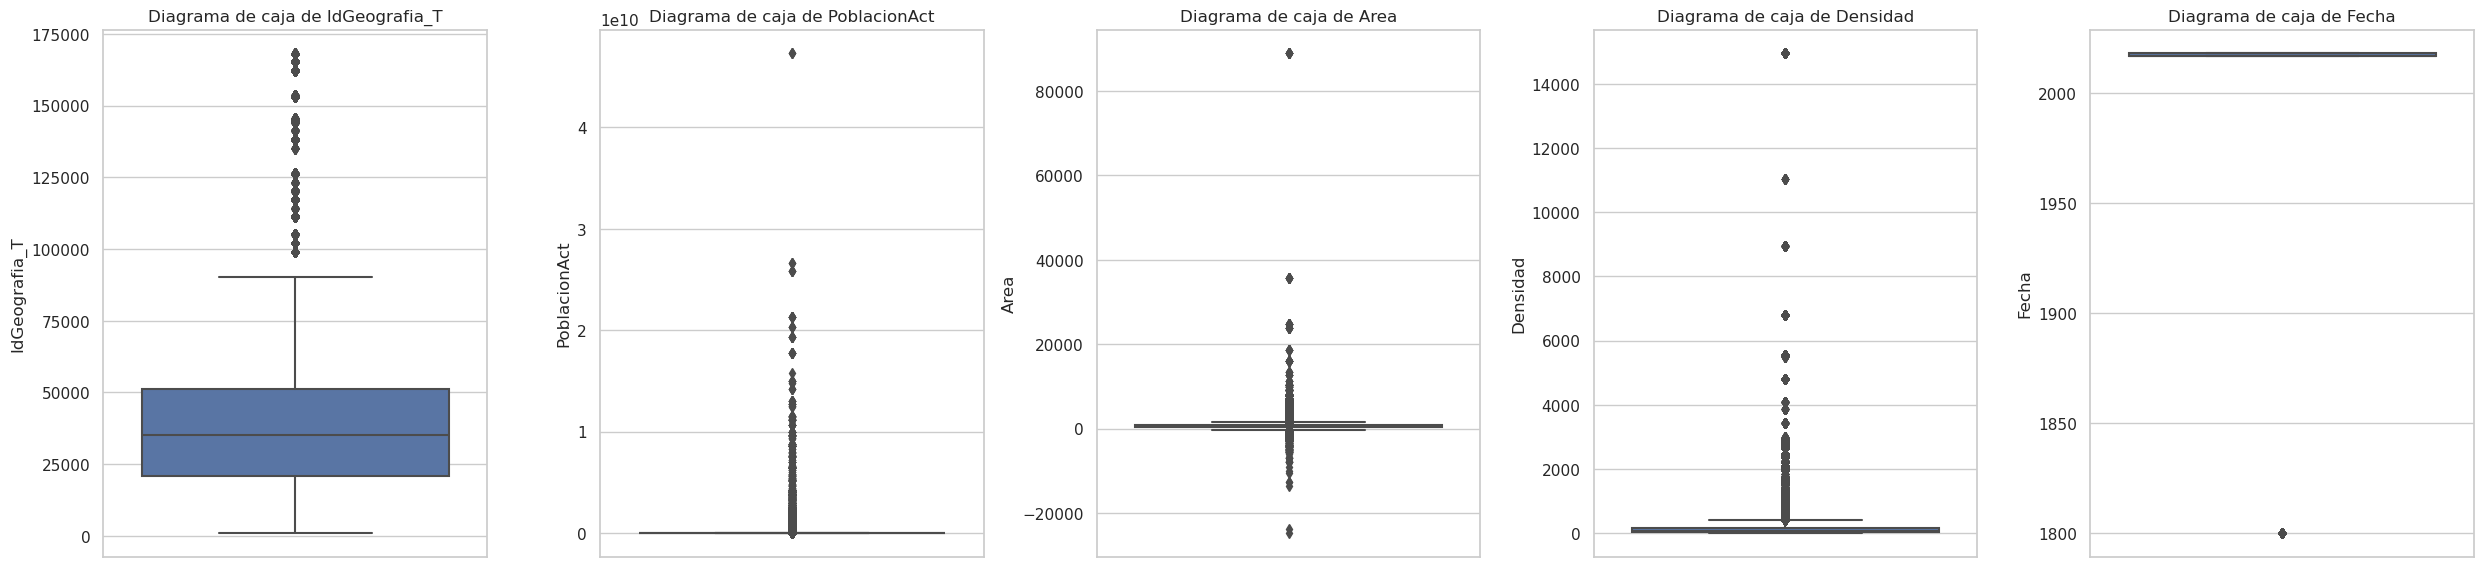

In [181]:
plot_numeric_box_plots(df_areas_numeric_vars, 1)

**1. Diagrama de Caja de IdGeografia_T**

- Distribución: La mayoría de los valores de IdGeografia_T se encuentran agrupados en el rango de 25,000 a 75,000, con algunos valores atípicos que superan los 100,000.
- Valores Atípicos: Hay varios valores atípicos por encima del rango superior (más de 125,000), lo que puede indicar registros especiales o errores de codificación.

**2. Diagrama de Caja de PoblacionAct**

- Distribución: La mayoría de los valores están muy concentrados cerca del mínimo, con una distribución muy sesgada hacia la derecha. Hay algunos valores extremadamente altos que parecen ser outliers significativos.
- Valores Atípicos: Existen valores extremadamente altos, que pueden representar áreas urbanas densamente pobladas. Sin embargo, la gran cantidad de outliers sugiere que la distribución no es uniforme y podría requerir un tratamiento especial.

**3. Diagrama de Caja de Area**

- Distribución: La mayor parte de los valores de Area están concentrados en un rango muy estrecho, con algunos valores extremadamente altos que actúan como outliers.
- Valores Negativos: Hay valores negativos, lo cual es inconsistente con lo que esperaríamos para un área. Esto sugiere errores en los datos que deben corregirse.
- Valores Atípicos: Los valores altos de área podrían corresponder a regiones geográficas excepcionalmente grandes, pero los valores negativos deben ser investigados y posiblemente eliminados.

**4. Diagrama de Caja de Densidad**

- Distribución: La densidad también muestra una distribución con varios valores atípicos extremos. La mayoría de los datos están concentrados cerca del valor mínimo, lo que indica una distribución sesgada.
- Valores Atípicos: Los valores muy altos de densidad podrían representar áreas muy densamente pobladas, pero la cantidad de outliers sugiere una distribución desigual.

**5. Diagrama de Caja de Fecha**

- Distribución: La mayoría de los valores de Fecha parecen estar en un rango reciente, pero hay un valor inusualmente bajo (posiblemente del año 1800) que es claramente un outlier.
- Valores Atípicos: El valor atípico de Fecha probablemente sea un error en los datos.


In [104]:
anios_conteo = df_areas_numeric_vars.groupBy("Fecha").count().orderBy("Fecha")
anios_conteo.show()


+-----+-----+
|Fecha|count|
+-----+-----+
| 1800| 4841|
| 2017|76318|
| 2018|64083|
+-----+-----+



Tiene sentido los outliers, las 12 ocurrencias con área demasiado grandes quedan en Alaska, y en efecto son grandes.

In [111]:
areas_not_dup.where(col("Area") > 40000 ).show()

+------------------+--------------------+-------------+-------------------+------+------------+-------+--------+-----+
|IdAreaDeServicio_T|NombreAreaDeServicio|IdGeografia_T|            Condado|Estado|PoblacionAct|   Area|Densidad|Fecha|
+------------------+--------------------+-------------+-------------------+------+------------+-------+--------+-----+
|          50122018|PBCBSAK Service A...|         2185|North Slope Borough|Alaska|     10972.0|88824.0|     0.0| 2018|
|          20982017|Alaska21989AK0130...|         6555|North Slope Borough|Alaska|     10972.0|88824.0|     0.0| 2017|
|          50112017|PBCBSAK Service A...|         2185|North Slope Borough|Alaska|     10972.0|88824.0|     0.0| 2017|
|          20982017|Alaska21989AK0130...|         2185|North Slope Borough|Alaska|     10972.0|88824.0|     0.0| 2017|
|          21002017|Alaska21989AK0130...|         2185|North Slope Borough|Alaska|     10972.0|88824.0|     0.0| 2017|
|          20962017|Alaska21989AK0130...|       

In [115]:
areas_not_dup.where(col("PoblacionAct") > 20000000 ).show()

+------------------+--------------------+-------------+-----------------+----------+------------+------+--------+-----+
|IdAreaDeServicio_T|NombreAreaDeServicio|IdGeografia_T|          Condado|    Estado|PoblacionAct|  Area|Densidad|Fecha|
+------------------+--------------------+-------------+-----------------+----------+------------+------+--------+-----+
|          32192017|HMO Service Area2...|        26073|  Isabella County|  Michigan|    6.4813E8| 578.0|   112.0| 2017|
|          51192017|Medica Connect395...|        20007|    Barber County|    Kansas|      4.11E7|1134.0|     4.0| 2017|
|          68092018|Indiana54192IN001...|        18013|     Brown County|   Indiana|    1.5552E8| 312.0|    50.0| 2018|
|          84762017|Ambetter from Pea...|        13157|   Jackson County|   Georgia|    8.0286E8| 342.0|   235.0| 2017|
|          70682018|Indiana54192IN001...|        18025|  Crawford County|   Indiana|    1.0514E8| 306.0|    34.0| 2018|
|          55422018|Buckeye Community...

Analizando los datos más extremos de la población actual, y tomando un ejemplo:

![Tabla Moviemientos](./imagenes/extremePopulation.png)

Y haciendo una simple búsqueda en google, la población de ese condado en el 2018 fue 249,964 y una densidad de 207,15 hab./km² por ende se debe hacer una validation de la data historica. 
En el caso del registro encontrado tiene la cifra exorbitante de 6,430,260,000 hab. y la densidad no es real.  

In [116]:
areas_not_dup.where(col("Densidad") > 14000 ).show()

+------------------+--------------------+-------------+-------------+----------+------------+----+--------+-----+
|IdAreaDeServicio_T|NombreAreaDeServicio|IdGeografia_T|      Condado|    Estado|PoblacionAct|Area|Densidad|Fecha|
+------------------+--------------------+-------------+-------------+----------+------------+----+--------+-----+
|         103082018|New Jersey - Medi...|       102051|Hudson County|New Jersey|    702463.0|47.0| 14946.0| 2018|
|         103902018|AmeriHealth Advan...|        34017|Hudson County|New Jersey|    702463.0|47.0| 14946.0| 2018|
|         102112018|New Jersey - Medi...|       102051|Hudson County|New Jersey|    702463.0|47.0| 14946.0| 2018|
|         101232018|New Jersey - Medi...|        34017|Hudson County|New Jersey|    702463.0|47.0| 14946.0| 2018|
|         102692018|New Jersey - Medi...|        34017|Hudson County|New Jersey|    702463.0|47.0| 14946.0| 2018|
|         105102018|AmeriHealth Advan...|        34017|Hudson County|New Jersey|    7024

Revisando los datos más extremos, para el anterior ejemplo, los datos no parecen logicos, la densidad de la poblacion se calcula generalmente como:

**Densidad = poblacion/Area** , si el área es muy pequena, pero la población es alta, la densidad debería ser extremadamente alta, pero en este caso, tener un valor de área que sea menor que la densidad no parece lógico.

Se debe preguntar al negocio, cuáles son los posibles errores de inconsistencia.

Hay un total de **87915** un gran porcentaje de la data entegada.

In [175]:
# Filtrar filas donde el área es menor que la densidad
inconsistencies = df_areas_numeric_vars.filter((col("Area") < col("Densidad")) | (col("PoblacionAct") > col("Area") * col("Densidad")))

# Mostrar las filas con inconsistencias
inconsistencies.count()

87915

In [176]:
areas_not_pop_errs = df_areas_numeric_vars.filter(~((col("Area") < col("Densidad")) | (col("PoblacionAct") > col("Area") * col("Densidad"))))
areas_not_dup_not_pop_err_not_negatives = areas_not_pop_errs.filter(col("Area") >= 0)
areas_not_dup_not_pop_err_not_negatives.count()

55492

In [177]:
# Eliminar filas que contengan valores NaN en cualquier columna
areas_not_dup_not_nan = areas_not_dup_not_pop_err_not_negatives.dropna()

# Mostrar las primeras filas del DataFrame sin valores NaN
areas_not_dup_not_nan.count()

53529

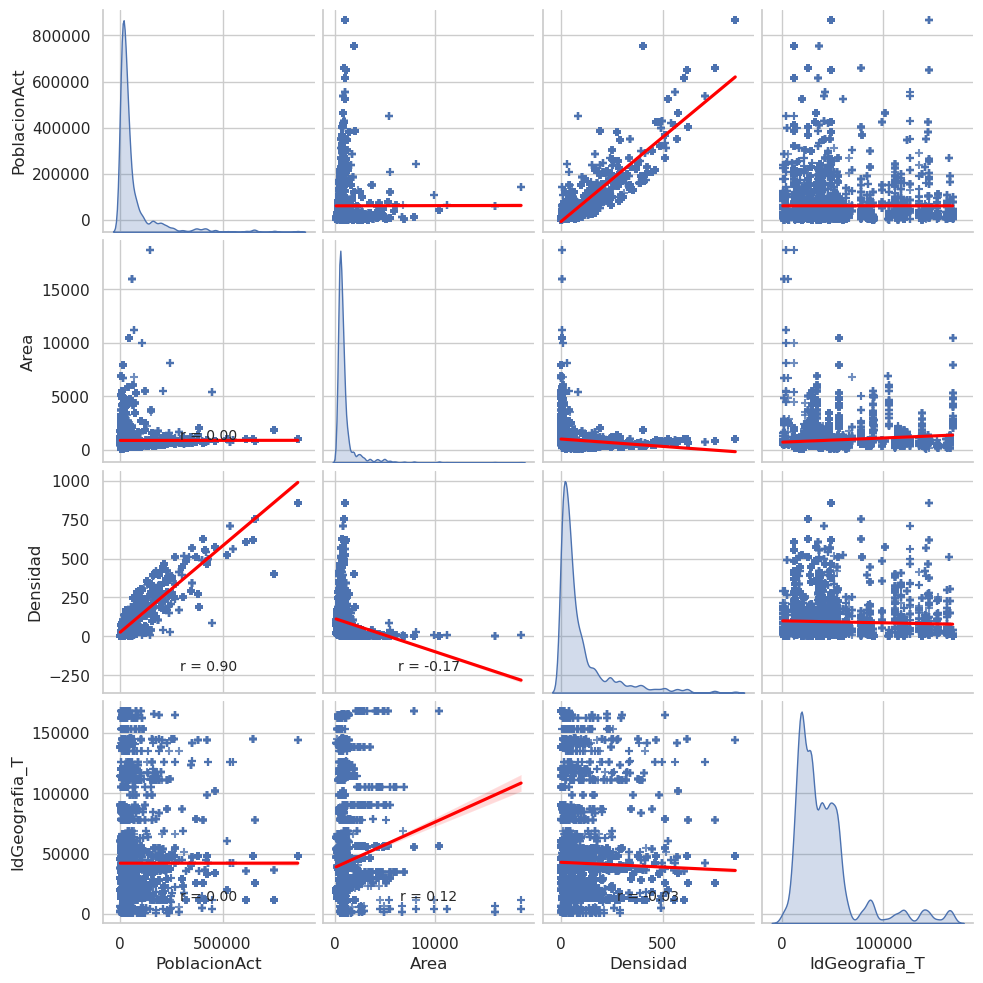

In [179]:
def plot_pairplot_with_corr(spark_df, numeric_columns):
    """
    Genera un gráfico de pares con coeficientes de correlación para las columnas numéricas de un DataFrame de Spark.

    Parámetros:
    - spark_df: DataFrame de Spark.
    - numeric_columns: Lista de columnas numéricas a utilizar para el gráfico de pares.

    Retorna:
    - None. La función muestra el gráfico de pares.
    """
    # Convertir las columnas numéricas del DataFrame de Spark a un DataFrame de Pandas
    df_nums = spark_df.select(numeric_columns).toPandas()
    
    def corrfunc(x, y, **kws):
        r, _ = pearsonr(x, y)
        ax = plt.gca()
        ax.annotate(f"r = {r:.2f}", xy=(0.5, 0.1), xycoords=ax.transAxes, ha='center', fontsize=10)

    # Crear el gráfico de pares con seaborn
    sns.pairplot(df_nums, diag_kind="kde", kind="reg", plot_kws={'line_kws': {'color': 'red'}}, 
                 markers="+").map_lower(corrfunc)

    plt.show()

# Ejemplo de uso
numeric_columns = ["PoblacionAct", "Area", "Densidad", "IdGeografia_T"]
plot_pairplot_with_corr(areas_not_dup_not_nan, numeric_columns)

**Relaciones Significativas:** 

La relación más fuerte es entre PoblacionAct y Densidad (r ≈ 0.90), lo cual es esperado y muestra que la densidad está estrechamente relacionada con la población.

**Relaciones Insignificantes:** 

Variables como IdGeografia_T no muestran correlación significativa con otras variables numéricas, lo que sugiere que es un campo más categórico.

**Distribución de Datos:** 
La asimetría en las variables sugiere la presencia de valores extremos o outliers, que podrían requerir un tratamiento adicional, como transformaciones de datos o análisis en subconjuntos.

En posibles modelos de regression podria Densidad y poblacion están fuertemente ligadas, y tendria problema de colinealidad.

In [200]:
areas_not_dup_not_nan.show(5)

+-------------+------------+------+--------+-----+
|IdGeografia_T|PoblacionAct|  Area|Densidad|Fecha|
+-------------+------------+------+--------+-----+
|        30101|      5011.0|1911.0|     3.0| 2018|
|        28111|     11571.0| 647.0|    18.0| 2017|
|        29099|    227771.0| 657.0|   347.0| 2017|
|        29111|     10000.0| 505.0|    20.0| 2017|
|        46087|      5695.0| 575.0|    10.0| 2018|
+-------------+------------+------+--------+-----+
only showing top 5 rows



In [204]:

df_pandas = areas_not_dup.toPandas()
df_grouped = df_pandas.groupby('Estado')['PoblacionAct'].max().reset_index()

state_abbrev = {
    "Alabama": "AL", "Alaska": "AK", "Arizona": "AZ", "Arkansas": "AR",
    "California": "CA", "Colorado": "CO", "Connecticut": "CT", "Delaware": "DE",
    "Florida": "FL", "Georgia": "GA", "Hawaii": "HI", "Idaho": "ID",
    "Illinois": "IL", "Indiana": "IN", "Iowa": "IA", "Kansas": "KS",
    "Kentucky": "KY", "Louisiana": "LA", "Maine": "ME", "Maryland": "MD",
    "Massachusetts": "MA", "Michigan": "MI", "Minnesota": "MN", "Mississippi": "MS",
    "Missouri": "MO", "Montana": "MT", "Nebraska": "NE", "Nevada": "NV",
    "New Hampshire": "NH", "New Jersey": "NJ", "New Mexico": "NM", "New York": "NY",
    "North Carolina": "NC", "North Dakota": "ND", "Ohio": "OH", "Oklahoma": "OK",
    "Oregon": "OR", "Pennsylvania": "PA", "Rhode Island": "RI", "South Carolina": "SC",
    "South Dakota": "SD", "Tennessee": "TN", "Texas": "TX", "Utah": "UT",
    "Vermont": "VT", "Virginia": "VA", "Washington": "WA", "West Virginia": "WV",
    "Wisconsin": "WI", "Wyoming": "WY"
}

df_grouped['State_Abbrev'] = df_grouped['Estado'].map(state_abbrev)

fig = px.choropleth(
    df_grouped,  
    locations='State_Abbrev', 
    locationmode="USA-states",
    scope="usa",
    color='PoblacionAct',
    color_continuous_scale="Viridis",
    title="Distribución de la Población por Estado"
)

fig.update_layout(
    autosize=False,
    width=1000, 
    height=700, 
    margin={"r":0,"t":30,"l":0,"b":0} 
)

fig.show()



Se vuelve a mostrar en caso de que no sea visible desde otro computador.

![DistribucionEstado](./imagenes/distEstado.png)

El análisis gráfico revela claramente errores en los datos y evidencia un problema de redundancia innecesaria.

**Problema de Consistencia de los Datos**

Al seleccionar el valor máximo de población por estado, se observan cifras extremadamente elevadas e incorrectas. Un ejemplo extremo es el estado de Texas, donde los datos muestran una población en miles de millones. Esto es inconsistente con los datos reales: según las estadísticas oficiales, la población de Texas en 2018 era de aproximadamente 28,510,878. Por lo tanto, es evidente que los registros en la tabla contienen errores significativos.

**Problema de Redundancia**

La información de población y área se repite innecesariamente en cada registro de servicio. Para optimizar y simplificar la estructura de la base de datos, sería recomendable extraer estos datos y almacenarlos en una tabla separada. Esto evitaría la duplicación y mejoraría la eficiencia del almacenamiento y la gestión de datos.

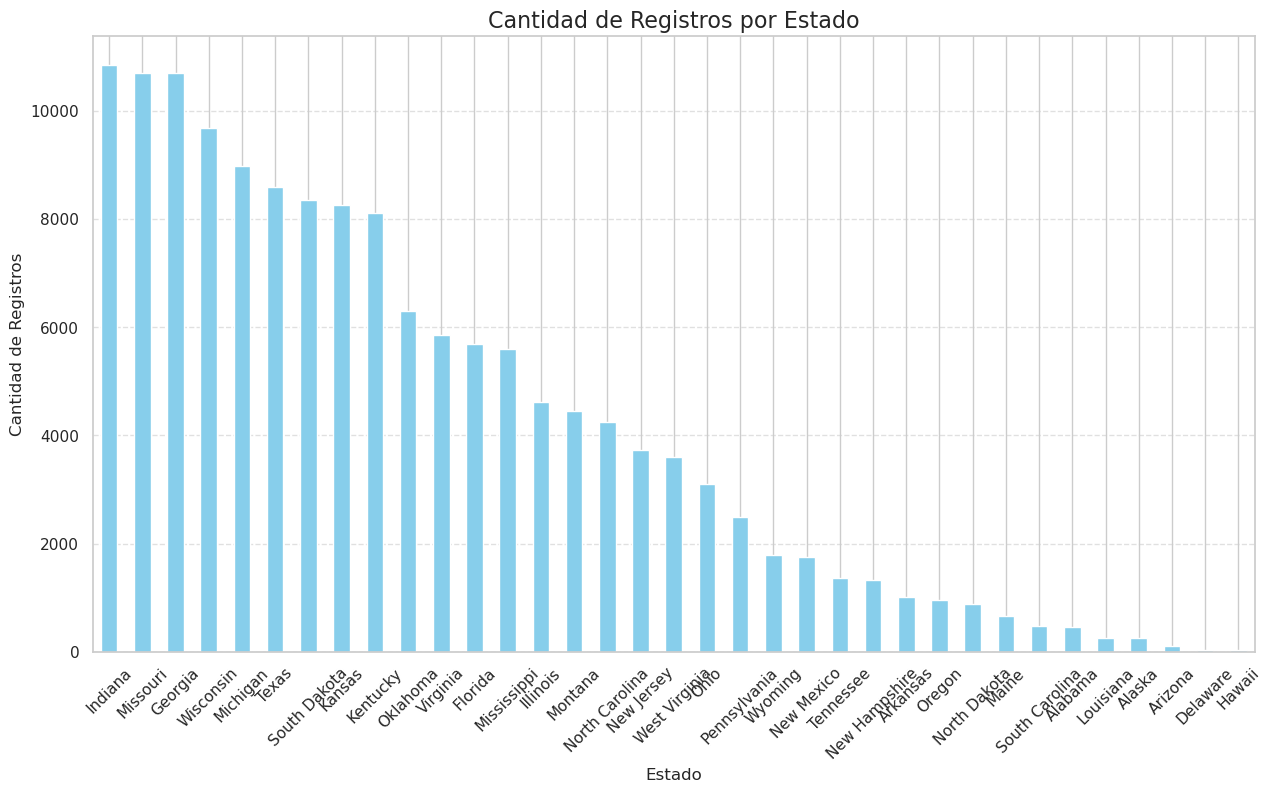

In [194]:

df_pandas = areas_not_dup.toPandas()

estado_counts = df_pandas['Estado'].value_counts()


plt.figure(figsize=(15, 8))
estado_counts.plot(kind='bar', color='skyblue')
plt.title("Cantidad de Registros por Estado", fontsize=16)
plt.xlabel("Estado", fontsize=12)
plt.ylabel("Cantidad de Registros", fontsize=12)
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.show()


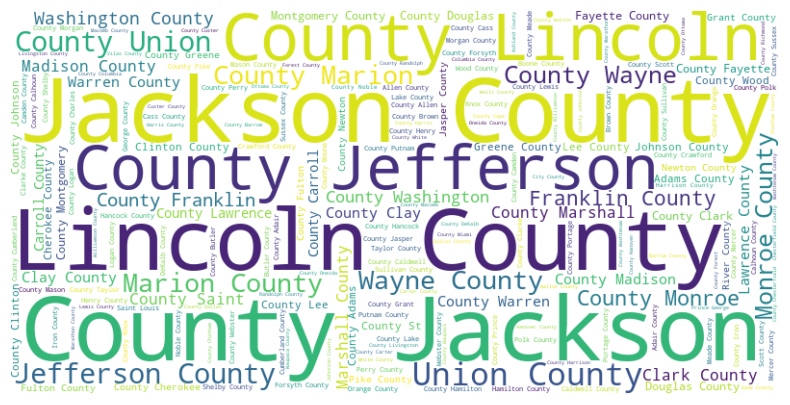

In [195]:
nombres_areas_servicio = areas_not_dup.select("Condado").rdd.flatMap(lambda x: x).collect()

texto_unido = " ".join(nombres_areas_servicio)

wordcloud = WordCloud(width=800, height=400, background_color='white').generate(texto_unido)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()


### Conclusiones

Las conclusiones se van a consolidar en un solo documento word.
